# Classify audio

In [1]:
from pathlib import Path

metadata_file = Path(r"D:\dataset\audio_mnist\audioMNIST_meta.txt")
dataset_path = Path(r"D:\dataset\audio_mnist\data")

In [2]:
import json
from IPython.display import display, JSON

with open(metadata_file, "r") as fd:
    metadata = json.loads(fd.read())
    display(JSON(metadata))

    nfolders = len(metadata.keys())

<IPython.core.display.JSON object>

In [3]:
SAMPLE_RATE = 16_000

#### Estimate audio length

### Convert audio to spectogram

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def load_audio(audio_path, target_sr=None):
    # Carga el audio
    y, sr = librosa.load(str(audio_path), sr=None)
    
    if target_sr is not None:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    return y

def fix_length(audio, size):
    return librosa.util.fix_length(audio, size=size)

def calculate_spectogram(audio):
    # Calcula el espectrograma (magnitud en escala dB)
    S = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    return S_db
    

##### Load and view spectogram

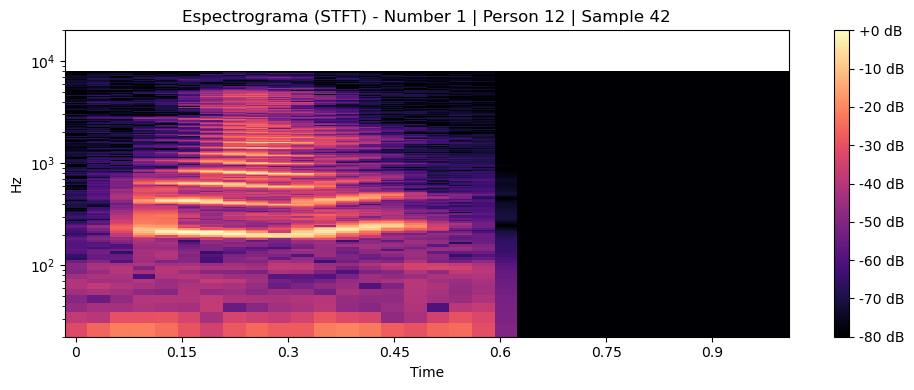

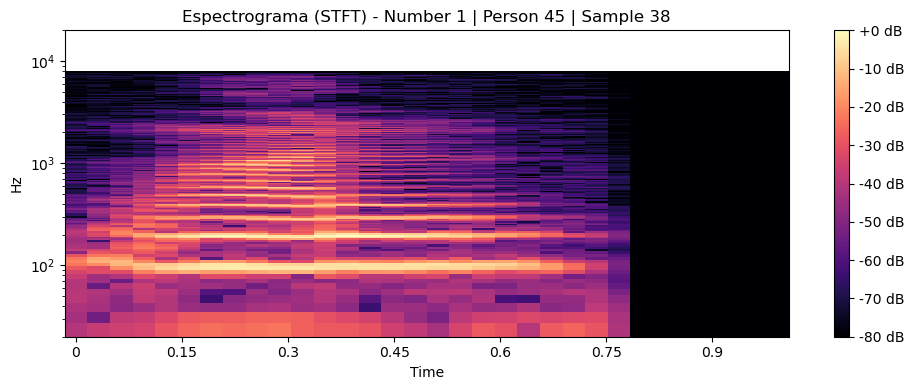

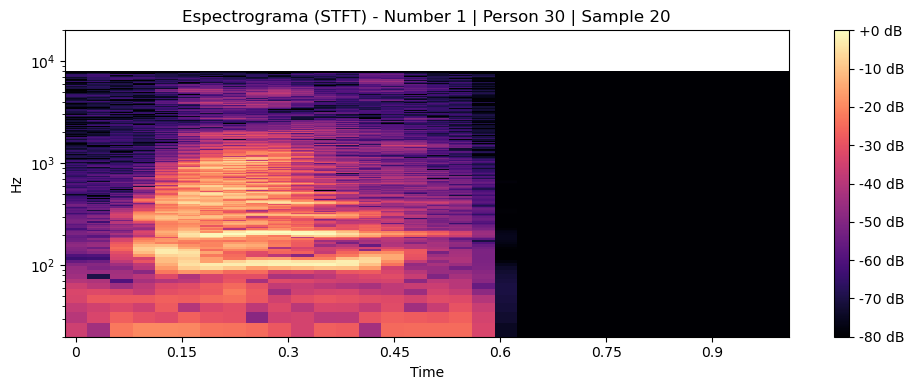

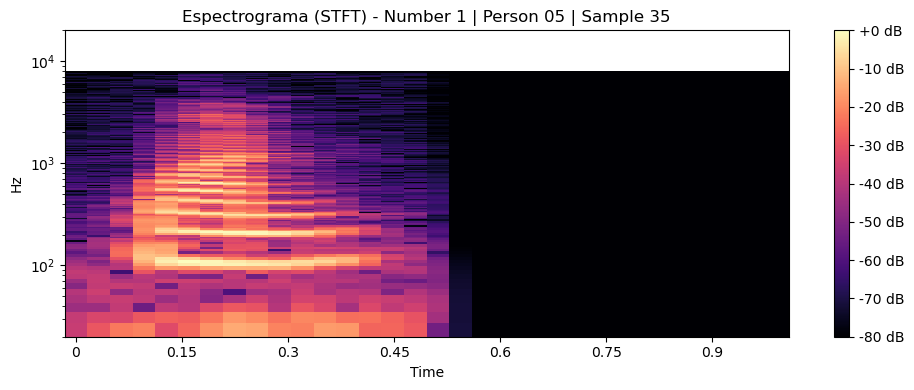

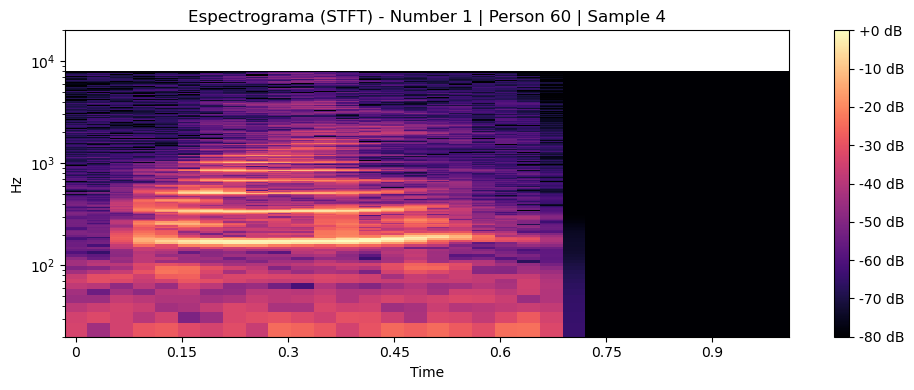

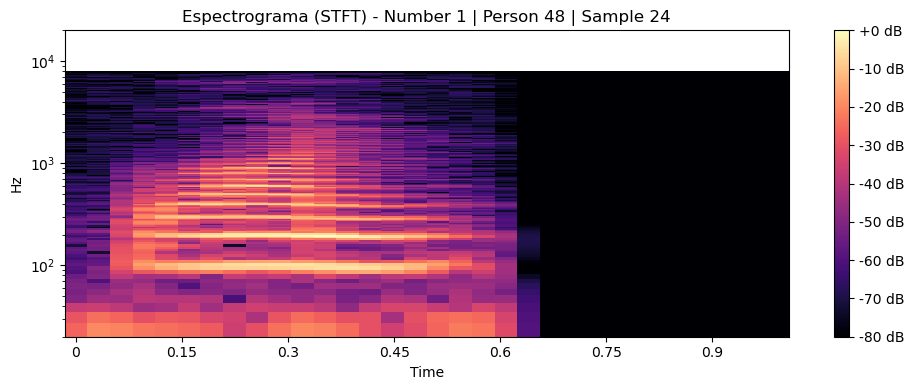

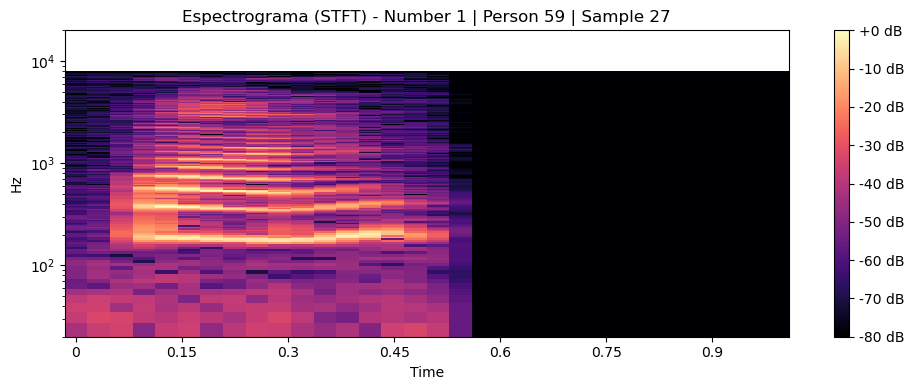

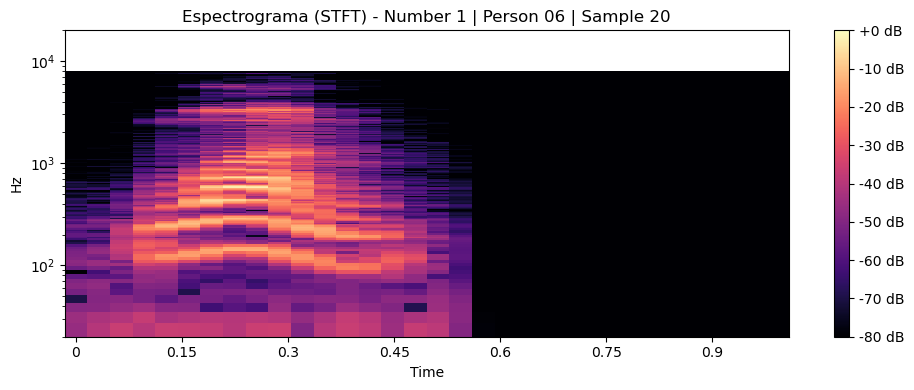

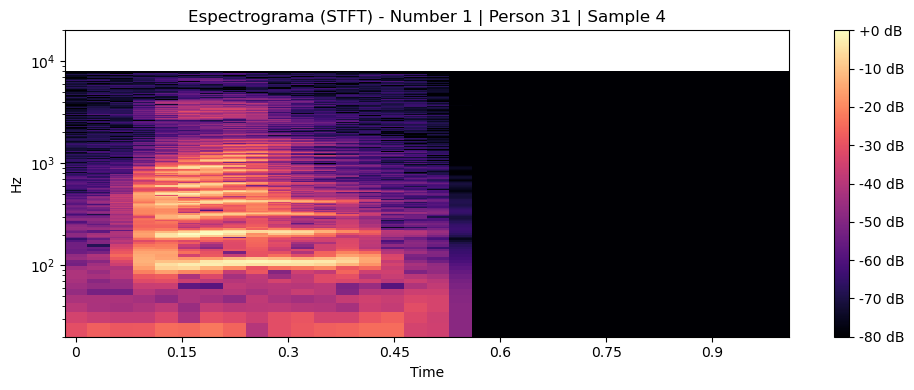

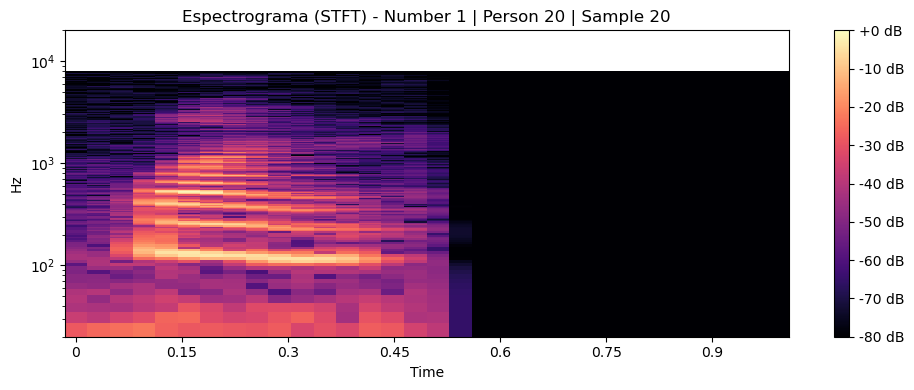

In [5]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

files = list(filter(lambda f : f.stem.startswith("1_"), dataset_path.rglob("*.wav")))

for fn in np.random.choice(files, 10):

    audio = load_audio(fn, target_sr=SAMPLE_RATE)
    audio = fix_length(audio, SAMPLE_RATE)
    S = calculate_spectogram(audio)
    
    display(Audio(fn))
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S, sr=SAMPLE_RATE, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    
    audio_name = fn.stem.split("_")
    plt.title(f"Espectrograma (STFT) - Number {audio_name[0]} | Person {audio_name[1]} | Sample {audio_name[2]}")
    plt.tight_layout()
    
    plt.yscale("log")
    plt.ylim(20, 20_000)  # limita a rango audible
    
    plt.show()

## Dataset

In [6]:
import torch
from torch.utils.data import Dataset
import pytorch_lightning as pl

SAMPLE_RATE = 16_000

class AudioMNISTDataset(Dataset):

    def __init__(self, datafolder, sample_rate=16_000, transform=None):
        self.__filepaths = list(datafolder.rglob("*.wav"))
        self.__sample_rate = sample_rate
    
    def __len__(self):
        return len(self.__filepaths)
    
    def __getitem__(self, idx):
        audio_path = self.__filepaths[idx]
        # Crear spectogram
        audio = load_audio(audio_path, target_sr=self.__sample_rate)
        audio = fix_length(audio, SAMPLE_RATE)
        S = calculate_spectogram(audio)
        
        # Create label
        label = int( audio_path.stem.split("_")[0] )

        # To tensor
        S_tensor = torch.tensor(S, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        # Normalize
        S_tensor = (S_tensor + 80) / 80
        
        S_tensor = S_tensor.unsqueeze(0) # Adds new channel at 0

        
        
        return S_tensor, label_tensor


In [7]:
audio_dataset = AudioMNISTDataset(dataset_path)

print(f"Dim dataset: {len(audio_dataset)}")

item = audio_dataset[0]
item[0].shape, item[1]

Dim dataset: 30000


(torch.Size([1, 1025, 32]), tensor(0))

torch.Size([1025, 32]) torch.Size([])


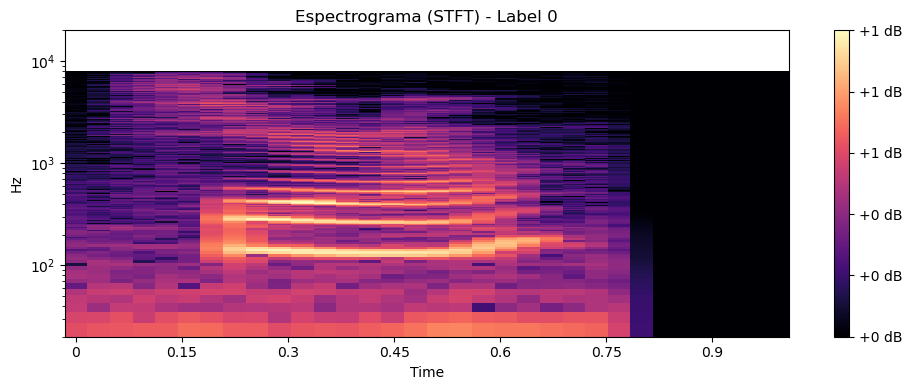

In [8]:
import numpy as np
import matplotlib.pyplot as plt

for it in item[0]:
    data = it.squeeze(0).numpy()
    print(it.shape, item[1].shape)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(data, sr=SAMPLE_RATE, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")

    plt.title(f"Espectrograma (STFT) - Label {item[1]}")
    plt.tight_layout()

    plt.yscale("log")
    plt.ylim(20, 20_000)  # limita a rango audible
    plt.show()

# # Crear un array 2D de ejemplo
# data = item[0].squeeze(0).numpy()
# 
# print(item[0].shape, item[1].shape)
# 
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(data, sr=SAMPLE_RATE, x_axis='time', y_axis='hz', cmap='magma')
# plt.colorbar(format="%+2.0f dB")
# 
# plt.title(f"Espectrograma (STFT) - Label {item[1]}")
# plt.tight_layout()
# 
# plt.yscale("log")
# plt.ylim(20, 20_000)  # limita a rango audible
# 
# plt.show()

### Model

In [9]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F

SEQ_LEN = 4

class SpeechClassifier(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.__h1 = 20
        self.__lstm_hidden_dim = 128

        self.__num_classes = 10

        self.__cnn_feats = self.__h1 * 128 * 16
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=self.__h1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.lstm = torch.nn.LSTM(
                input_size=self.__cnn_feats, 
                hidden_size=self.__lstm_hidden_dim,
                batch_first=True
        )
        self.fc = torch.nn.Linear(self.__lstm_hidden_dim, self.__num_classes)

    def forward(self, x):
        logits = self.model(x)
        
        # Splits temporal sequence
        batch_size, _, F, T = logits.shape
        assert T % SEQ_LEN == 0, f"Invalid {SEQ_LEN=}. It must be divisible by {T=}"

        T_step = T // SEQ_LEN
        logits_seq = logits.unfold(dimension=2, size=T_step, step=T_step)
        logits_seq = logits_seq.permute(0, 3, 1, 2, 4) # (BATCH_SIZE, SEQ_LEN, C=1, F, T_step)
        
        #logits_seq = logits_seq.flatten()
        logits_seq = torch.nn.Flatten()(logits_seq)
        
        logits_seq = logits_seq.view(batch_size, SEQ_LEN, -1)  # (batch, seq_len, feature_dim)
        
        rnn_out, _ = self.lstm(logits_seq)
        out = rnn_out[:, -1, :]
        out = self.fc(out)
        
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
        

In [10]:
import torch.nn.functional as F

X = torch.rand(2, 1, 1025, 32) # batch, channel, h, w
label = torch.randint(0, 9, (2,)) # batch

model = SpeechClassifier()

y_pred = model(X)
print(y_pred.shape)
#print(label, y_pred.argmax(1), y_pred)

#print(F.cross_entropy(y_pred, label))

#(y_pred.argmax(dim=1) == label).float().mean()

torch.Size([2, 10])


#### Data split

In [11]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split

class AudioMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, sample_rate=16000):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.sample_rate = sample_rate

    def setup(self, stage=None):
        full_dataset = AudioMNISTDataset(self.data_dir, sample_rate=self.sample_rate)
        
        train_len = int(0.7 * len(full_dataset))
        val_len = int(0.2 * len(full_dataset))
        test_len = len(full_dataset) - train_len - val_len

        generator = torch.Generator().manual_seed(42)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_len, val_len, test_len], generator=generator
        )

        print(f"Data module summary")
        print(f" - Train length: {train_len}")
        print(f" - Validation length: {val_len}")
        print(f" - Test length: {test_len}")
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0)


#### Training

In [12]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from datetime import datetime

# Logger
logger = TensorBoardLogger("tb_logs_lstm", name="audio_mnist_classifier")

# Data
audio_data_module = AudioMNISTDataModule(dataset_path, batch_size=32, sample_rate=16_000)

# Modelo
model = SpeechClassifier()

# EarlyStopping
earlystop_callback = EarlyStopping(
    monitor="val_acc",
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode="max"
)

timestamp_name = datetime.now().strftime("%d%h%y_%H%M")

# ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    save_top_k=1,               # guarda solo el mejor modelo
    mode="max",
    dirpath="models-lstm",
    filename=f"best-checkpoint-{timestamp_name}",
    save_weights_only=False,
    verbose=True
)

# Entrenador
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=15,
    callbacks=[earlystop_callback, checkpoint_callback],
    logger=logger,
    
)

# Entrenamiento
trainer.fit(model, datamodule=audio_data_module)

# Cargar el mejor modelo antes de test
best_model_path = checkpoint_callback.best_model_path
best_model = SpeechClassifier.load_from_checkpoint(best_model_path)

# Evaluar con el mejor modelo
trainer.test(best_model, datamodule=audio_data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 200    | train
1 | lstm  | LSTM       | 21.0 M | train
2 | fc    | Linear     | 1.3 K  | train
---------------------------------------------
21.0 M    Trainable params
0         Non-trainable params
21.0 M    Total params
84.158    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Data module summary
 - Train length: 21000
 - Validation length: 6000
 - Test length: 3000


Sanity Checking: |                                                                                      | 0/? …

D:\python\.ai_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\python\.ai_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                             | 0/? …

Validation: |                                                                                           | 0/? …

Metric val_acc improved. New best score: 0.798
Epoch 0, global step 657: 'val_acc' reached 0.79783 (best 0.79783), saving model to 'D:\\python\\speech_recog\\notebook\\models-lstm\\best-checkpoint-30Jul25_1516.ckpt' as top 1


Validation: |                                                                                           | 0/? …

Metric val_acc improved by 0.188 >= min_delta = 0.0. New best score: 0.985
Epoch 1, global step 1314: 'val_acc' reached 0.98550 (best 0.98550), saving model to 'D:\\python\\speech_recog\\notebook\\models-lstm\\best-checkpoint-30Jul25_1516.ckpt' as top 1


Validation: |                                                                                           | 0/? …

Epoch 2, global step 1971: 'val_acc' was not in top 1


Validation: |                                                                                           | 0/? …

Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.989
Epoch 3, global step 2628: 'val_acc' reached 0.98900 (best 0.98900), saving model to 'D:\\python\\speech_recog\\notebook\\models-lstm\\best-checkpoint-30Jul25_1516.ckpt' as top 1


Validation: |                                                                                           | 0/? …

Epoch 4, global step 3285: 'val_acc' was not in top 1


Validation: |                                                                                           | 0/? …

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.992
Epoch 5, global step 3942: 'val_acc' reached 0.99183 (best 0.99183), saving model to 'D:\\python\\speech_recog\\notebook\\models-lstm\\best-checkpoint-30Jul25_1516.ckpt' as top 1


Validation: |                                                                                           | 0/? …

Epoch 6, global step 4599: 'val_acc' was not in top 1


Validation: |                                                                                           | 0/? …

Epoch 7, global step 5256: 'val_acc' was not in top 1


Validation: |                                                                                           | 0/? …

Monitored metric val_acc did not improve in the last 3 records. Best score: 0.992. Signaling Trainer to stop.
Epoch 8, global step 5913: 'val_acc' was not in top 1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Data module summary
 - Train length: 21000
 - Validation length: 6000
 - Test length: 3000


D:\python\.ai_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                              | 0/? …

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9900000095367432
        test_loss           0.03472449630498886
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.03472449630498886, 'test_acc': 0.9900000095367432}]

---
### Demo

For this demo, new audios have been created using Amazon Polly.

In [13]:
def load_audio_data(audio_path):
    sample_rate = 16_000
    
    audio = load_audio(audio_path, target_sr=sample_rate)
    audio = fix_length(audio, sample_rate)
    S = calculate_spectogram(audio)
    
    S_tensor = torch.tensor(S, dtype=torch.float32)
    
    S_tensor = (S_tensor + 80) / 80

    S_tensor = S_tensor.unsqueeze(0).unsqueeze(0)

    return S_tensor

def get_result(model, x):
    logits = model(x)
    return logits.argmax(dim=1)

In [18]:
from IPython.display import display, Audio

filename = r"D:\dataset\audio_mnist\demo\russel_australia_standard\5.wav"
display(Audio(filename))

model_path = r".\models-lstm\best-checkpoint-30Jul25_1516.ckpt"
best_model = SpeechClassifier.load_from_checkpoint(model_path)

S_tensor = load_audio_data(filename).cuda()
print(S_tensor.shape)
pred = get_result(best_model, S_tensor)

print("Predicción: ", pred.item())


torch.Size([1, 1, 1025, 32])
Predicción:  5


#### Model summary

In [32]:
from torchinfo import summary

model = SpeechClassifier().cuda()
summary(model, input_size=(1, 1, 1025, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SpeechClassifier                         [1, 10]                   --
├─Sequential: 1-1                        [1, 20, 512, 16]          --
│    └─Conv2d: 2-1                       [1, 20, 1025, 32]         200
│    └─ReLU: 2-2                         [1, 20, 1025, 32]         --
│    └─MaxPool2d: 2-3                    [1, 20, 512, 16]          --
├─LSTM: 1-2                              [1, 4, 128]               21,038,080
├─Linear: 1-3                            [1, 10]                   1,290
Total params: 21,039,570
Trainable params: 21,039,570
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 90.71
Input size (MB): 0.13
Forward/backward pass size (MB): 5.25
Params size (MB): 84.16
Estimated Total Size (MB): 89.54

---------------------------------